In [68]:
#my alpha vantage api key to get data
#alpha vantage
key = 'DMBPCGJ6BBY2GAC3'
from alpha_vantage.timeseries import TimeSeries
from alpha_vantage.techindicators import TechIndicators
from pandas_datareader import data

from datetime import datetime,timedelta,date
import time

import progressbar
from time import sleep
import random 


import seaborn as sns 
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.simplefilter('ignore', np.RankWarning)

In [69]:
ts = TimeSeries(key,output_format = 'pandas')
#daily open close average and volume of daily stock
day_stock, dat_meta = ts.get_daily(symbol = 'MSFT',outputsize = 'full')

In [77]:
day_stock.iloc[:100,1]

date
2021-10-07    296.640
2021-10-06    293.630
2021-10-05    290.398
2021-10-04    287.750
2021-10-01    289.980
               ...   
2021-05-24    251.160
2021-05-21    248.330
2021-05-20    247.950
2021-05-19    243.230
2021-05-18    246.410
Name: 2. high, Length: 100, dtype: float64

Current stock price: 296.64
mean change: 0.25775034293552807
std: 2.6640340654894716
mean overall movement: 11.083264746227707


[========================================================================] 100%


Average return: 0.6129518540000011


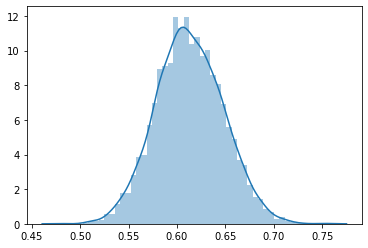

In [83]:
#price at start and end, expiry,ticker 
#checks to see the average return on a bulish credit spread 
#uses the buy and sell price for when the option expires 
def bull_cred(ticker,years,buy_price,sell_price,expiry):
    
    ts = TimeSeries(key,output_format = 'pandas')
    day_stock, dat_meta = ts.get_daily(symbol = ticker,outputsize = 'full')
    
    #Use the closing price as this is the price the european 
    stock_price  = day_stock.iloc[:365*years,1]
    
    #calculates the number of days till the option expires 
    delta = datetime.strptime(expiry, '%Y-%m-%d') - datetime.today()
    days = delta.days
    
    #current price
    cur_price = stock_price[0]
    print('Current stock price:', cur_price)
    
    #diff of daily prices, uses all of stock prices history to calculate the change 
    diff_arr = np.array([])
    for i in range(0,len(stock_price)-1):
        #goes latest to earliest 
        change = stock_price[i]-stock_price[i+1]
        diff_arr = np.append(diff_arr,np.array([change]))
        
    print('mean change:',np.mean(diff_arr))
    print('std:',np.std(diff_arr))
    print('mean overall movement:',np.mean(diff_arr) * days)
    
    
    y = 0
    # number of times the random price change is itterated over 
    iter = 100000
    bar = progressbar.ProgressBar(maxval=iter, \
    widgets=[progressbar.Bar('=', '[', ']'), ' ', progressbar.Percentage()])
    bar.start()
    
    end_rng = np.array([])
    
    #use random change in stock price between days to find the distbution of returns over a given period 
    for i in range(0,iter):
        x = 0
        for j in range(0,days): 
            x += diff_arr[random.randint(0,len(diff_arr)-1)] 
        end_rng = np.append(end_rng,np.array([x]))
        bar.update(i + 1)  
    
    bar.finish() 
    
    #profit loss array 
    pl_array = np.array([])
    
    #works out the profit and loss based on the how far the end price is from each and if the options expires itm
    for i in end_rng:
        #profit loss starts off as 0
        pl = 0
        #end_rng is the difference in price so current needs to be added back on find the final price 
        i = i + cur_price 
        buy_diff  = i - buy_price  
        if buy_diff  < 0:
            pl += buy_diff
        sell_diff = i - sell_price 
        if sell_diff < 0:
            pl -= sell_diff
        pl_array = np.append(pl_array,pl)
    
    #average profit for option 
    print('Average return:',np.mean(pl_array))
    
    #random outputs of options 
    pl_array_norm = np.array([])
    
    #tries n number of iterations on the code to look at the distrubution of the average return 
    for i in range(0,5000):
        h = 0
        for j in range(0,2000):
            h += pl_array[random.randint(0,len(pl_array)-1)] 
        h = h/2000
        pl_array_norm = np.append(pl_array_norm,np.array([h]))
            
           
    #shows the distrubution of loss and gain without taking into aco
    sns.distplot(pl_array_norm ,kde = True)
    
bull_cred('MSFT',2,285,290,'2021-11-21')   

In [84]:
# finds the probablity of stock moving beyond a given strike price at or before the expiry date (as it is a us option )
def exp_option_us(ticker,years,end_date,target_price):#ticker and target percentage probability 
    #stock price 
    ts = TimeSeries(key,output_format = 'pandas')
    day_stock, dat_meta = ts.get_daily(symbol = ticker,outputsize = 'full')
    # uses the high and low prices to see if the stock goes beyond the price on a given day.
    # 900 days chosen arbitrarily but can easily be changed dependent on the stock 
    prev_days = 365*years
    stock_price = day_stock.iloc[:prev_days,3].to_numpy()
    stock_price_high = day_stock.iloc[:prev_days,1].to_numpy()
    stock_price_low = day_stock.iloc[:prev_days,2].to_numpy()
    
    #current price
    cur_price = stock_price[0]
    print(cur_price)
    
    #works out the target price of the stock 
    price_change = target_price - cur_price
    
    #diff of daily prices
    #look at the difference between days and between the high and low and given price for the day 
    diff_arr = np.array([])
    diff_max = np.array([])
    diff_min = np.array([])
    for i in range(0,len(stock_price)-1):
        change = stock_price[i]-stock_price[i+1]
        max_change = stock_price_high[i] - stock_price[i+1]
        min_change = stock_price_low[i] - stock_price[i+1] 
        diff_arr = np.append(diff_arr,np.array([change]))
        diff_max = np.append(diff_arr,np.array([max_change]))
        diff_min = np.append(diff_arr,np.array([min_change]))
    
    #calculates the number of days till the option expires 
    delta = datetime.strptime(end_date, '%Y-%m-%d') - datetime.today()
    days = delta.days
    
    
    y = 0
    iter = 500000
    
    for i in range(0,iter):
        x = 0
        for j in range(0,days):
            # do x max and min 
            x += diff_arr[random.randint(0,len(diff_arr)-1)] 
            xmax = x + diff_max[random.randint(0,len(diff_arr)-1)]
            xmin = x + diff_min[random.randint(0,len(diff_arr)-1)]
            #Checks to see if the price is outside of the defined price in which case it expires 
            if (xmin > price_change and price_change > 0) or (xmax < price_change and price_change < 0):
                y += 1
                break
     
    #Chance of experiation over the target price 
    chance = y/iter
    
    print('Chance of expiration:',chance ) 
    
    
exp_option_us('MSFT',1,'2021-11-16',290)

294.85
Chance of expiration: 0.712624


In [85]:
#same as the previous but does not check if the price maves beyond the strike price before due to it being a european option.
def exp_option_eur(ticker,years,end_date,target_price):#ticker and target percentage probability 
    #stock price 
    ts = TimeSeries(key,output_format = 'pandas')
    day_stock, dat_meta = ts.get_daily(symbol = ticker,outputsize = 'full')
    #year sees how far to look back with the data 
    stock_price = day_stock.iloc[:365*years,3].to_numpy()
    
    #current price
    cur_price = stock_price[0]
    print(cur_price)
    
    #works out the target price of the stock 
    price_change = target_price - cur_price
    
    #diff of daily prices
    diff_arr = np.array([])
    for i in range(0,len(stock_price)-1):#
        #goes latest to earliest 
        change = stock_price[i]-stock_price[i+1]
        diff_arr = np.append(diff_arr,np.array([change]))
    
    #calculates the number of days till the option expires 
    delta = datetime.strptime(end_date, '%Y-%m-%d') - datetime.today()
    days = delta.days
    
    print('mean price change:',np.mean(diff_arr))
    print('std price change:',np.std(diff_arr))
    print('mean movement:',np.mean(diff_arr) * days)
    
    y = 0
    iter = 100000
    bar = progressbar.ProgressBar(maxval=iter, \
    widgets=[progressbar.Bar('=', '[', ']'), ' ', progressbar.Percentage()])
    bar.start()
    
    end_rng = np.array([])
    
    for i in range(0,iter):
        x = 0
        #print()
        for j in range(0,days):
            # do x max and min 
            x += diff_arr[random.randint(0,len(diff_arr)-1)] 
            #print(x)
        #print(x)
        end_rng = np.append(end_rng,np.array([x]))
        if (x > price_change and price_change > 0) or (x < price_change and price_change < 0):
            #print('Y')
            y += 1
        bar.update(i + 1)
        
    chance = y/iter
    
    bar.finish() 
    
    print('Chance of expiration:',chance ) 
    return chance,end_rng
    
    
chance,end_rng = exp_option_eur('MSFT',2,'2021-11-21',280)
print(chance)

294.85
mean price change: 0.257764060356653
std price change: 3.449518187746983
mean movement: 11.08385459533608


Chance of expiration: 0.12334
0.12334
